In [1]:
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from matplotlib import rc, rcParams
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from local_algorithms import LocalSgd, LocalShuffling
from datasets import get_dataset
from first_order import RestNest
from loss_functions import LogisticRegression
from utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['mathtext.fontset'] = 'cm'
# Multiple plots in one figure: code below
# import matplotlib.backends.backend_pdf as bf
# <code for plt>
# pdf = bf.PdfPages("./output.pdf")
# for fig in xrange(1, plt.figure().number):
#         pdf.savefig( fig )
# pdf.close()

In [2]:
num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)

2021-02-12 13:58:01,430	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.152.37.155',
 'raylet_ip_address': '10.152.37.155',
 'redis_address': '10.152.37.155:6379',
 'object_store_address': '/tmp/ray/session_2021-02-12_13-58-00_932452_87607/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-12_13-58-00_932452_87607/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-12_13-58-00_932452_87607',
 'metrics_export_port': 63967,
 'node_id': '4d7bb584d3a48df7c08c7fc98891695e3565b04d'}

In [3]:
A, b = get_dataset('a9a', data_path='datasets/')
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
L = loss.smoothness
l2 = L / n
loss.l2 = l2
x0 = np.zeros(dim)
n_epoch = 100
batch_size = 8
it_max = (n_epoch * n) // batch_size
trace_len = 300

Computing the smoothness constant via SVD, it may take a few minutes...


In [4]:
rest = RestNest(loss=loss, it_max=4000, doubling=True)
rest_tr = rest.run(x0=x0)
rest_tr.compute_loss_of_iterates()

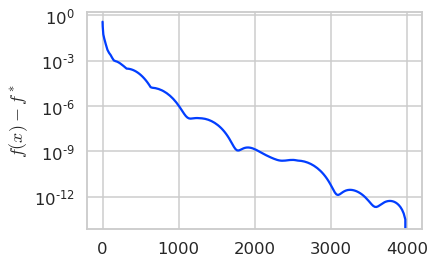

In [5]:
rest.trace.plot_losses()
plt.yscale('log')

In [6]:
it_local = 200
sgd_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) / it_local
sgd_decay_coef = l2 / 2
sgd_lr_max = sgd_lr0
sgd = LocalSgd(loss=loss, it_local=it_local, lr_max=sgd_lr_max, lr0=sgd_lr0, lr_decay_coef=sgd_decay_coef, it_start_decay=0,
          it_max=n*100//(batch_size*it_local), n_seeds=1, batch_size=batch_size, trace_len=100, iid=True)
sgd.run(x0=x0)
sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
sgd.trace.compute_loss_of_iterates()

In [7]:
rr_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size)
rr_decay_coef = l2 / 7
rr_lr_max = rr_lr0
rr = LocalShuffling(reshuffle=True, loss=loss, lr_max=rr_lr_max, lr0=rr_lr0, lr_decay_coef=rr_decay_coef, iid=True, 
                    epoch_start_decay=0, it_max=100, n_seeds=1, batch_size=batch_size, trace_len=100)
rr.run(x0=x0)
rr.trace.compute_loss_of_iterates()

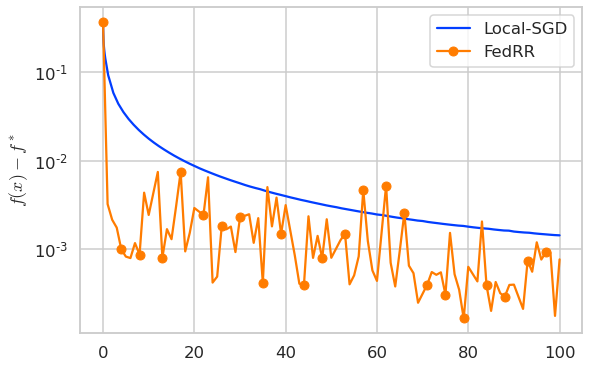

In [8]:
plt.figure(figsize=(9, 6))
sgd.trace.plot_losses(label='Local-SGD')
rr.trace.plot_losses(label='FedRR', marker='o')
plt.yscale('log')
plt.legend()
# plt.savefig('fed_a9a.pdf', dpi=300, bbox_inches='tight')